In [274]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
 

# Define file paths
share_prices_file = 'data/de_shareprices_daily.csv'
companies_file = 'data/de_companies.csv'
output_file = 'data/BMW.DE_transformed_data.csv'
model_path = 'data/trained_model.pkl'

# ETL Process Class
class ETLProcess:
    def __init__(self, share_prices_file, companies_file):
        self.share_prices_file = share_prices_file
        self.companies_file = companies_file

    def extract_data(self, company_ticker):
        try:
            # Load share prices and companies data
            share_prices = pd.read_csv(self.share_prices_file, delimiter=';')
            companies = pd.read_csv(self.companies_file, delimiter=';')

            # Filter for the given company ticker
            company_data = companies[companies['Ticker'] == company_ticker]
            if company_data.empty:
                print(f"Company {company_ticker} not found!")
                return None, None

            company_prices = share_prices[share_prices['Ticker'] == company_ticker]
            return company_data, company_prices
        except Exception as e:
            print(f"Error during extraction: {e}")
            return None, None

    def transform_data(self, company_prices):
        try:
            # Fill missing values
            company_prices.fillna(method='ffill', inplace=True)
            company_prices.fillna(method='bfill', inplace=True)

            # Convert Date column to datetime format
            company_prices['Date'] = pd.to_datetime(company_prices['Date'])

            # Extract features from Date
            company_prices['Day_of_Week'] = company_prices['Date'].dt.day_name()
            company_prices['Month'] = company_prices['Date'].dt.month
            company_prices['Year'] = company_prices['Date'].dt.year
            company_prices['Day_of_Month'] = company_prices['Date'].dt.day

            # Calculate percentage change
            company_prices['Price_Change'] = company_prices['Close'].pct_change() * 100

            # Categorize price movements
            def categorize_change(change):
                if change >= 3:
                    return 'High Rise'
                elif 0 < change < 3:
                    return 'Low Rise'
                elif -0.5 <= change <= 0.5:
                    return 'Stay'
                elif -3 < change < 0:
                    return 'Low Fall'
                else:
                    return 'High Fall'

            company_prices['Category'] = company_prices['Price_Change'].apply(categorize_change)
            return company_prices
        except Exception as e:
            print(f"Error during transformation: {e}")
            return None

    def load_data(self, transformed_data, output_file):
        try:
            transformed_data.to_csv(output_file, index=False)
            print(f"Transformed data saved to {output_file}")
        except Exception as e:
            print(f"Error during loading: {e}")

    def run_etl(self, company_ticker, output_file):
        company_data, company_prices = self.extract_data(company_ticker)
        if company_prices is None:
            print("Extraction failed. Aborting ETL process.")
            return

        transformed_data = self.transform_data(company_prices)
        if transformed_data is None:
            print("Transformation failed. Aborting ETL process.")
            return

        self.load_data(transformed_data, output_file)

# Testing with BMW.DE Run ETL Process
etl = ETLProcess(share_prices_file, companies_file)
etl.run_etl(company_ticker='BMW.DE', output_file=output_file)

# Load Transformed Data and Prepare for Modeling
data = pd.read_csv(output_file)
columns_to_drop = ['Ticker', 'SimFinId', 'Date', 'Category', 'Adj. Close', 'Shares Outstanding']
X = data.drop(columns=columns_to_drop, axis=1)
y = data['Category']

# Encode categorical features
if 'Day_of_Week' in X.columns:
    X = pd.get_dummies(X, columns=['Day_of_Week'], drop_first=True)

# Train the Machine Learning Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Save the list of feature names during model training
feature_names = X_train.columns.tolist()

# Evaluate the Model
y_pred = model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred))

# Save the Trained Model
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

# Predict Next Day's Market Movement
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Use the most recent data for prediction
recent_data = data.tail(1).copy()  # Get the last row of data
recent_data['Day_of_Week'] = pd.Categorical(recent_data['Day_of_Week'])
recent_data = pd.get_dummies(recent_data, columns=['Day_of_Week'], drop_first=True)

# Align the prediction dataset with the training features
for feature in feature_names:
    if feature not in recent_data.columns:
        recent_data[feature] = 0  # Add missing features with default value 0

# Reorder columns to match the training data
X_recent = recent_data[feature_names]

# Predict the next day's movement
next_day_prediction = model.predict(X_recent)
print(f"Prediction for the next day: {next_day_prediction[0]}")


Error during extraction: [Errno 2] No such file or directory: 'data/de_shareprices_daily.csv'
Extraction failed. Aborting ETL process.
Test Set Evaluation:
              precision    recall  f1-score   support

   High Fall       0.94      0.79      0.86        19
   High Rise       1.00      0.71      0.83        17
    Low Fall       0.97      0.99      0.98       112
    Low Rise       0.97      1.00      0.99       181
        Stay       1.00      1.00      1.00        47

    accuracy                           0.97       376
   macro avg       0.98      0.90      0.93       376
weighted avg       0.97      0.97      0.97       376

Prediction for the next day: Low Rise


In [275]:
df=pd.read_csv(output_file)
df['log_returns']= np.log(df['Close']/df['Close'].shift(1)).dropna() *100
df['log_returns']

0            NaN
1      -0.423550
2       0.084854
3       0.302462
4       2.904966
          ...   
1248    0.462050
1249   -0.571574
1250   -1.392094
1251   -0.359651
1252    0.598702
Name: log_returns, Length: 1253, dtype: float64

In [276]:
##for when all companies are available 
bmw=df[df['Ticker']=='BMW.DE']
dri=df[df['Ticker']=='DRI.DE']
dte=df[df['Ticker']=='DTE.DE']
mbg=df[df['Ticker']=='MBG.DE']
vow=df[df['Ticker']=='VOW.DE']

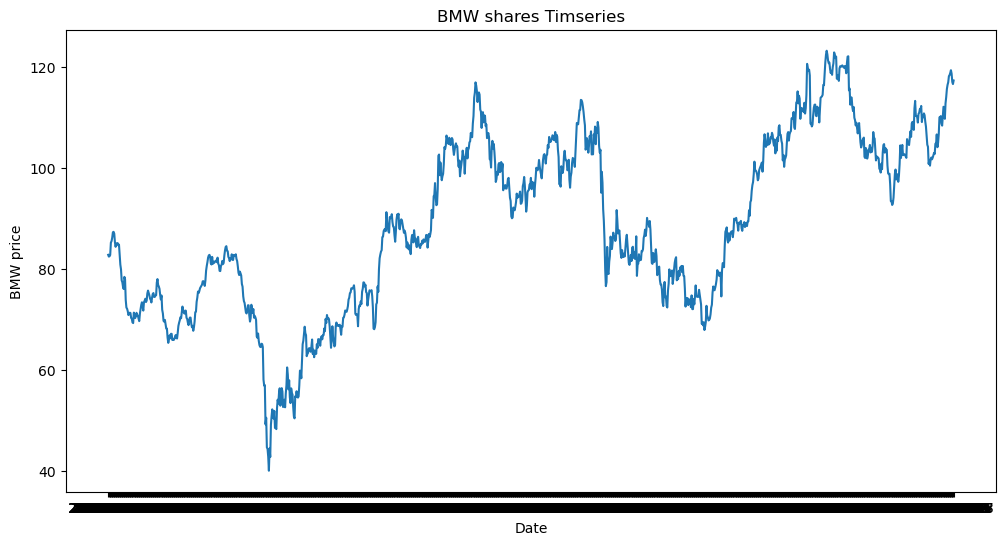

In [277]:
plt.figure(figsize=(12,6))
plt.plot(bmw['Date'], bmw['Close'],linestyle='-')
plt.xlabel('Date')
plt.ylabel('BMW price')
plt.title('BMW shares Timseries')
plt.show()

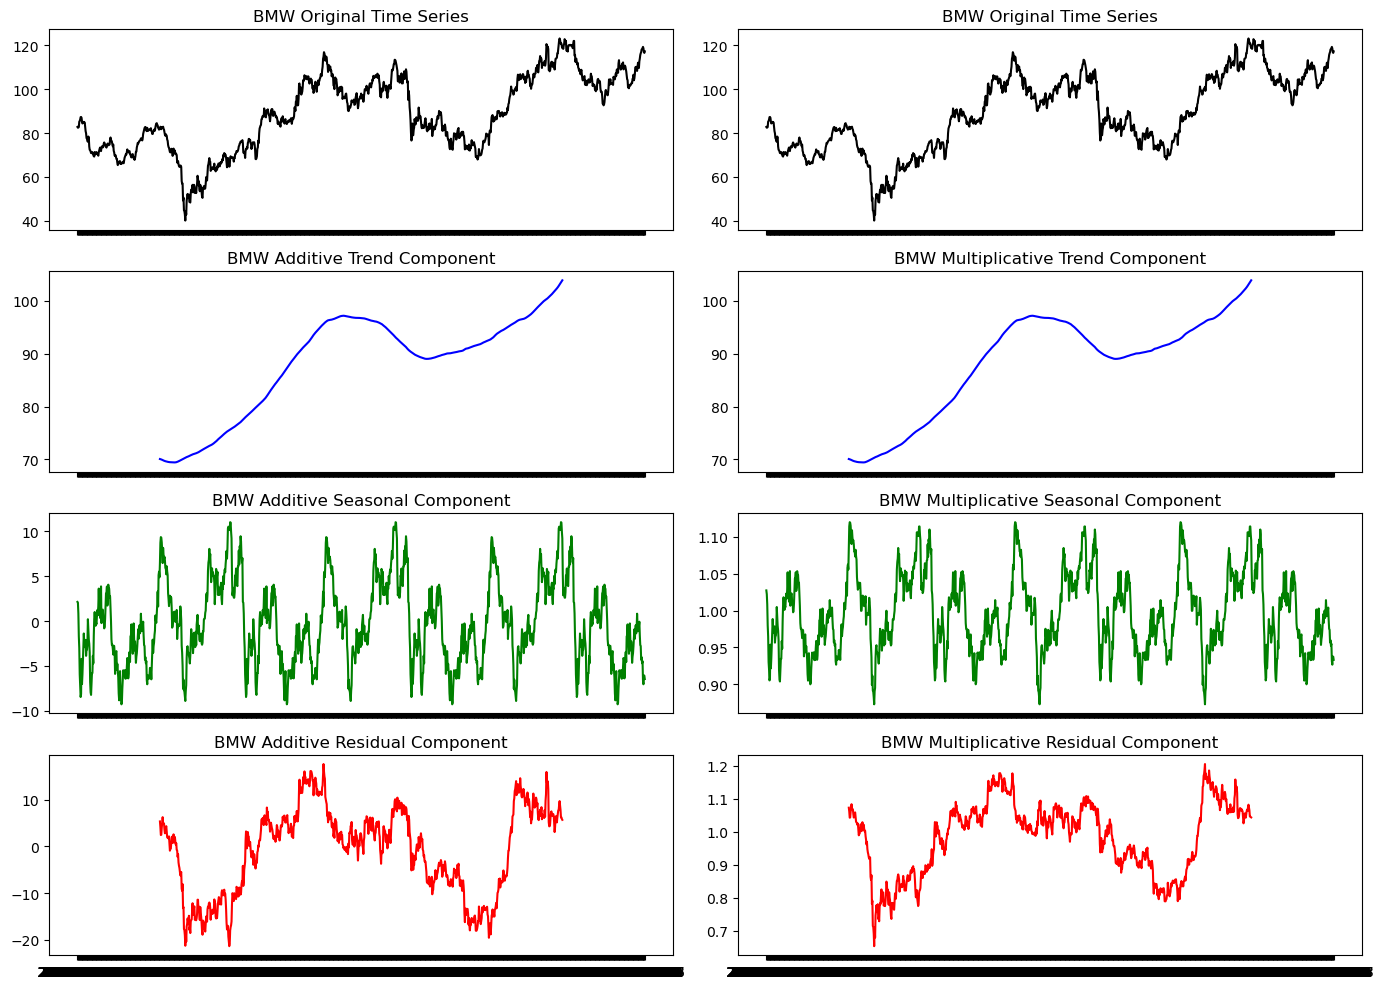

In [278]:
##additive and multiplicative for bmw company
# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(bmw["Close"], model="additive", period=365)
multiplicative_decomposition = seasonal_decompose(bmw["Close"], model="multiplicative", period=365)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(bmw['Date'], bmw["Close"], color="black")
axes[0, 0].set_title("BMW Original Time Series")

axes[1, 0].plot(bmw['Date'], additive_decomposition.trend, color="blue")
axes[1, 0].set_title("BMW Additive Trend Component")

axes[2, 0].plot(bmw['Date'], additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("BMW Additive Seasonal Component")

axes[3, 0].plot(bmw['Date'], additive_decomposition.resid, color="red")
axes[3, 0].set_title("BMW Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(bmw['Date'], bmw["Close"], color="black")
axes[0, 1].set_title("BMW Original Time Series")

axes[1, 1].plot(bmw['Date'], multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("BMW Multiplicative Trend Component")

axes[2, 1].plot(bmw['Date'], multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("BMW Multiplicative Seasonal Component")

axes[3, 1].plot(bmw['Date'], multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("BMW Multiplicative Residual Component")

plt.tight_layout()
plt.show()

In [279]:
bmw=bmw[bmw['log_returns'].notnull()]


/Users/eduardomartinezacha/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'PACF plot for Closing Price in log format')

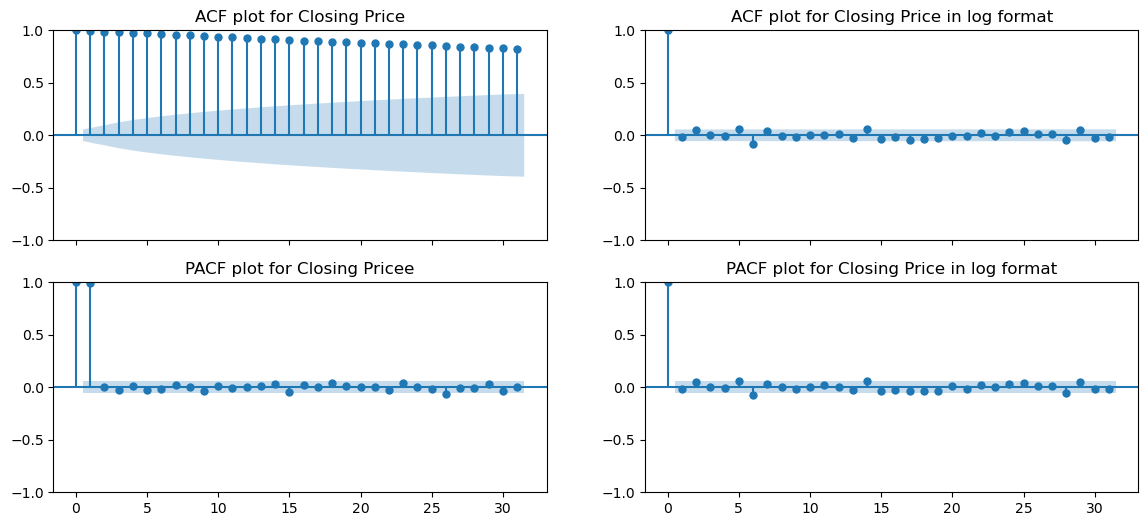

In [280]:
fig, axes=plt.subplots(2,2,figsize=(14,6),sharex=True)
plot_acf( bmw['Close'],ax=axes[0,0])
axes[0,0].set_title('ACF plot for Closing Price')
plot_pacf( bmw['Close'],ax=axes[1,0])
axes[1,0].set_title('PACF plot for Closing Pricee')
plot_acf( bmw['log_returns'],ax=axes[0,1])
axes[0,1].set_title('ACF plot for Closing Price in log format')
plot_pacf( bmw['log_returns'],ax=axes[1,1])
axes[1,1].set_title('PACF plot for Closing Price in log format')


In [281]:
adf_test=adfuller(bmw['Close'])
print(f'p val is {adf_test[1]}')
adf_test_log=adfuller(bmw['log_returns'])
print(f'the p val for close in log format {adf_test_log[1]}')

p val is 0.6023225259580013
the p val for close in log format 3.546536755605243e-27


In [282]:
training_data=bmw[bmw['Date']<'2024-03-01']
testing_data=bmw[bmw['Date']>'2024-03-01']

In [283]:
model=arch_model(training_data['log_returns'].dropna(),lags=2, vol='Constant',dist='t').fit(disp='off')
print(model.summary())

                  Constant Mean - Constant Variance Model Results                   
Dep. Variable:                  log_returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                Constant Variance   Log-Likelihood:               -2550.70
Distribution:      Standardized Student's t   AIC:                           5107.40
Method:                  Maximum Likelihood   BIC:                           5122.78
                                              No. Observations:                 1246
Date:                      Fri, Mar 07 2025   Df Residuals:                     1245
Time:                              14:46:27   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

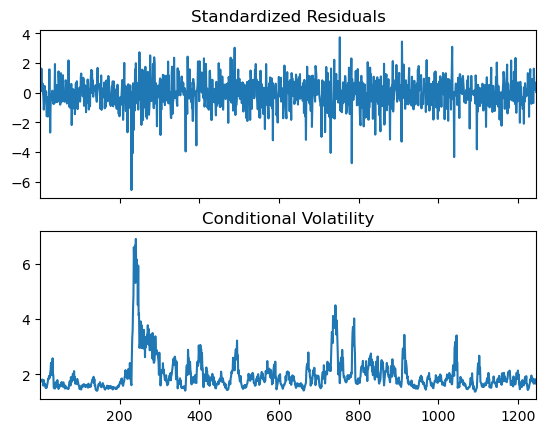

In [284]:

residuals=model.resid
residuals=residuals.dropna

fig = arch_bmw_model.plot()
plt.show()

In [285]:
for p in range(1, 6):  # Test small ranges first
    for q in range(1, 6):
        try:
            model = arch_model(bmw['log_returns'],lags=2, vol='ARCH', p=p, q=q, dist='t').fit(disp='off')
            if model.aic < best_aic:
                best_aic = model.aic
                best_pq = (p, q)
        except:
            continue

print(f"✅ Best (p, q): {best_pq} with AIC: {best_aic}")


✅ Best (p, q): (1, 1, 1) with AIC: 4996.673651450532


In [292]:
##make an arch model
arch_bmw_model= arch_model(training_data['log_returns'],mean='AR',lags=2,vol='ARCH',p=1,q=1,dist='t').fit(disp='off')
print(arch_bmw_model.summary())

                              AR - ARCH Model Results                               
Dep. Variable:                  log_returns   R-squared:                      -0.001
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                             ARCH   Log-Likelihood:               -2539.50
Distribution:      Standardized Student's t   AIC:                           5091.01
Method:                  Maximum Likelihood   BIC:                           5121.77
                                              No. Observations:                 1244
Date:                      Fri, Mar 07 2025   Df Residuals:                     1241
Time:                              14:47:58   Df Model:                            3
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

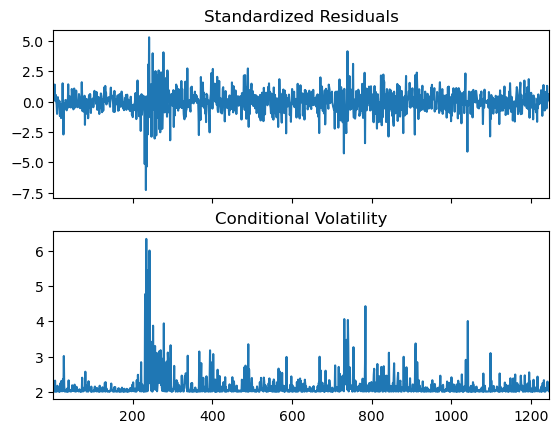

In [293]:
fig = arch_bmw_model.plot()
plt.show()




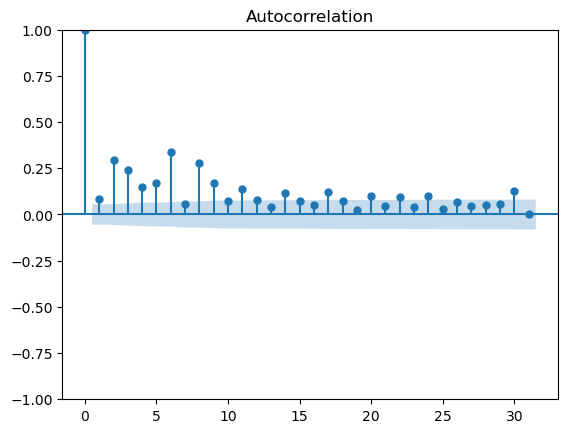

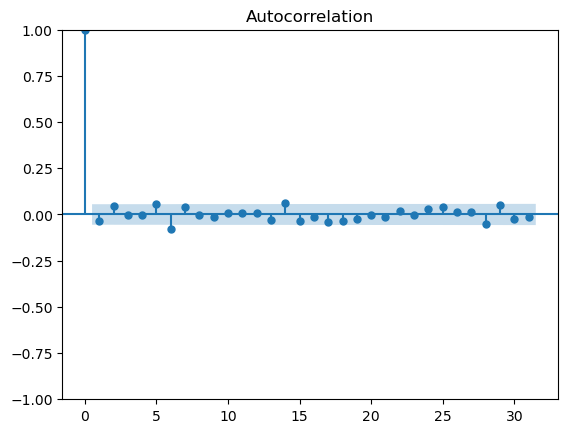

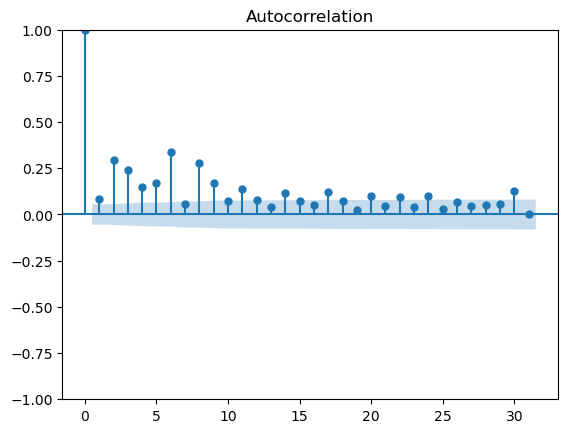

In [294]:

r=arch_bmw_model.resid.dropna()
rsquared=r**2
plot_acf(r)
plot_acf(rsquared)

In [318]:
##make a forecast

forecast= arch_bmw_model.forecast(horizon=5)
forecast_v=np.sqrt(forecast.variance.iloc[-1])

# ⚠️ Fix Scaling Issue: Use Mean Absolute Deviation (MAD) Instead of STD
actual_volatility = testing_data['log_returns'].abs().mean()  # Use mean absolute deviation (MAD)
forecast_median = forecast_v.median()  # Get median forecasted volatility

# Scale forecasted volatility using a ratio that maintains realistic values
scaling_factor = actual_volatility / forecast_median
forecast_v *= scaling_factor

# Print forecasted volatility values for verification
print(forecast_v)

forecast_dates = pd.date_range(training_data['Date'].iloc[-1], periods=5+1, freq="D")[1:]
forecast_dates

forecasts_df=pd.DataFrame({'dates':forecast_dates,'forecast':forecast_v})
forecasts_df['dates']=pd.to_datetime(forecasts_df['dates'])
forecasts_df=forecasts_df.set_index(forecasts_df['dates'])
forecasts_df

h.1    0.618728
h.2    0.668747
h.3    0.676814
h.4    0.678163
h.5    0.678390
Name: 1246, dtype: float64


,dates,forecast
dates,,
2024-03-01,2024-03-01,0.618728
2024-03-02,2024-03-02,0.668747
2024-03-03,2024-03-03,0.676814
2024-03-04,2024-03-04,0.678163
2024-03-05,2024-03-05,0.678390


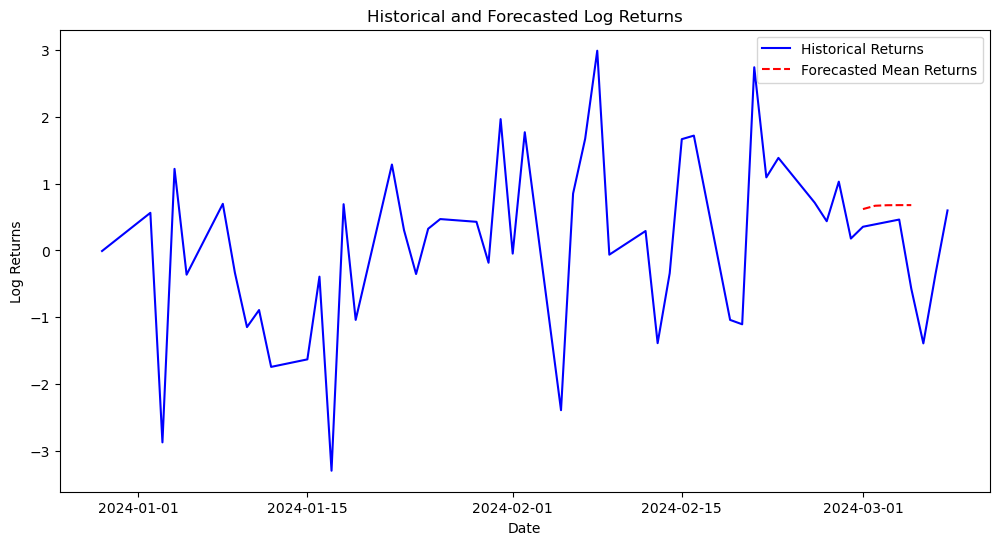

In [320]:
# Ensure date columns are in datetime format
bmw['Date'] = pd.to_datetime(bmw['Date'])
forecasts_df.index = pd.to_datetime(forecasts_df.index)  # Ensure index is datetime

# ✅ Corrected Plot Code
plt.figure(figsize=(12, 6))

# Plot historical log returns
plt.plot(bmw['Date'].iloc[-50:], bmw["log_returns"].iloc[-50:], label="Historical Returns", color="blue")

# Plot Forecasts (Fixed Variable Name)
plt.plot(forecasts_df.index, forecasts_df['forecast'], label="Forecasted Mean Returns", color="red", linestyle="dashed")

# Titles and Labels
plt.title("Historical and Forecasted Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend()
plt.show()

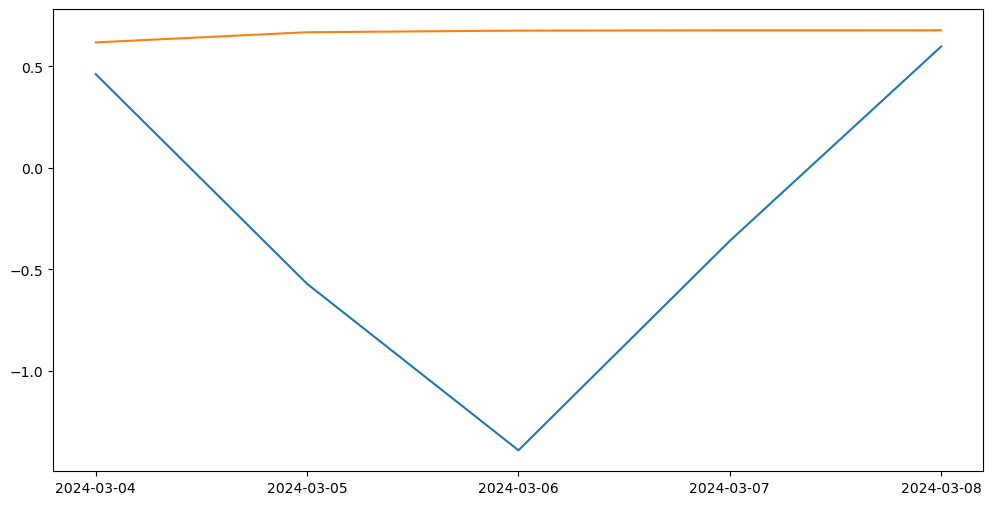

In [305]:
plt.figure(figsize=(12,6))
plt.plot(testing_data['Date'], testing_data['log_returns'])
plt.plot(testing_data['Date'], forecast_v.values)

In [162]:
bmw['Date']=pd.to_datetime(bmw['Date'])


In [163]:

last_date=bmw['Date'].iloc[-1]
last_date
volatility_forecast = np.sqrt(forecast.variance.iloc[-1])


future_dates=pd.date_range(start=last_date + pd.Timedelta(days=1),periods=20,freq='B')

# Create a DataFrame for the forecasted volatility
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Volatility': volatility_forecast.values})
forecast_df.set_index('Date', inplace=True)




In [164]:
last_date

Timestamp('2024-03-08 00:00:00')

In [165]:
volatility_forecast

h.01    2.016950
h.02    2.171992
h.03    2.197494
h.04    2.201840
h.05    2.202585
h.06    2.202713
h.07    2.202735
h.08    2.202738
h.09    2.202739
h.10    2.202739
h.11    2.202739
h.12    2.202739
h.13    2.202739
h.14    2.202739
h.15    2.202739
h.16    2.202739
h.17    2.202739
h.18    2.202739
h.19    2.202739
h.20    2.202739
Name: 1252, dtype: float64

In [166]:
forecast_df
# Create forecasted dates
forecast_dates = pd.date_range(bmw['Date'].iloc[-1], periods=20+1, freq="D")[1:]
forecast_dates

DatetimeIndex(['2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-16',
               '2024-03-17', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22', '2024-03-23', '2024-03-24',
               '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28'],
              dtype='datetime64[ns]', freq='D')

<Figure size 1200x500 with 0 Axes>

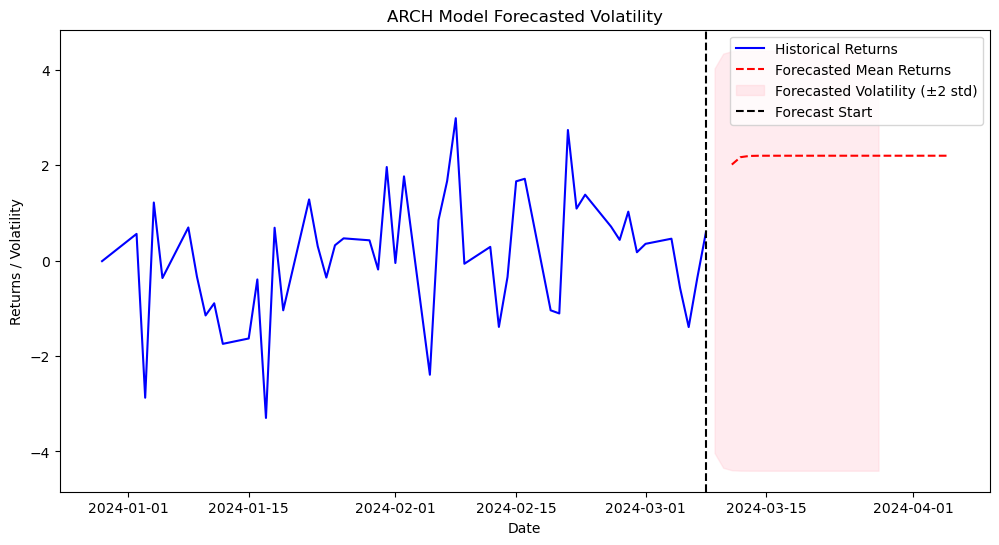

In [ ]:
# Plot actual and forecasted volatility
plt.figure(figsize=(12,5))

# Plot historical volatility (rolling standard deviation)

# Plot historical returns and forecasted volatility
plt.figure(figsize=(12, 6))
plt.plot(bmw['Date'].iloc[-50:], bmw["log_returns"].iloc[-50:], label="Historical Returns", color="blue")
plt.plot(forecast_df.index, volatility_forecast, label="Forecasted Mean Returns", color="red", linestyle="dashed")

plt.fill_between(forecast_dates, 
                 -2 * forecast_df["Forecasted_Volatility"], 
                 2 * forecast_df["Forecasted_Volatility"], 
                 color="pink", alpha=0.3, label="Forecasted Volatility (±2 std)")

plt.axvline(x=bmw['Date'].iloc[-1], color="black", linestyle="--", label="Forecast Start")
plt.legend()
plt.title("ARCH Model Forecasted Volatility")
plt.xlabel("Date")
plt.ylabel("Returns / Volatility")
plt.show()

In [308]:
 bmw["log_returns"].iloc[-50:]

1203   -0.008959
1204    0.562878
1205   -2.874125
1206    1.221194
1207   -0.362977
1208    0.697561
1209   -0.334585
1210   -1.147867
1211   -0.892740
1212   -1.743878
1213   -1.631296
1214   -0.392815
1215   -3.298504
1216    0.692113
1217   -1.039974
1218    1.286001
1219    0.304235
1220   -0.353392
1221    0.323990
1222    0.469393
1223    0.428350
1224   -0.184744
1225    1.965949
1226   -0.047726
1227    1.769623
1228   -2.392141
1229    0.851395
1230    1.671980
1231    2.989980
1232   -0.063662
1233    0.290698
1234   -1.388404
1235   -0.340904
1236    1.665790
1237    1.718827
1238   -1.040368
1239   -1.105985
1240    2.742361
1241    1.093775
1242    1.385221
1243    0.715551
1244    0.437150
1245    1.029577
1246    0.177612
1247    0.354281
1248    0.462050
1249   -0.571574
1250   -1.392094
1251   -0.359651
1252    0.598702
Name: log_returns, dtype: float64

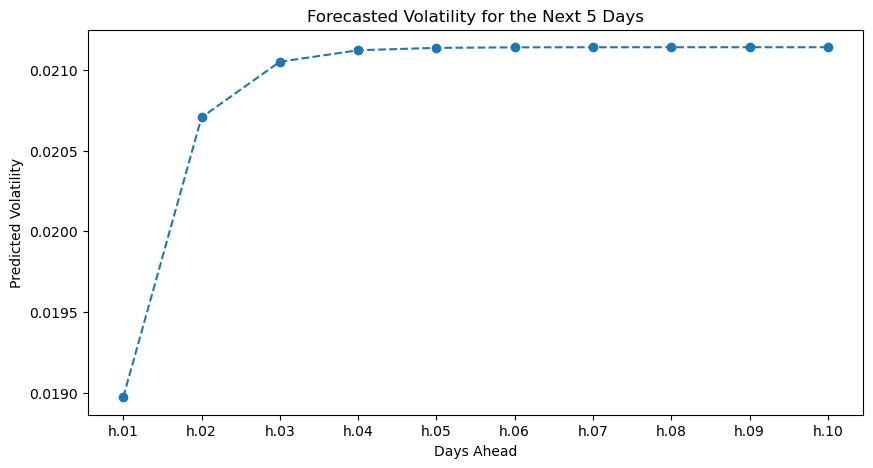

In [21]:
plt.figure(figsize=(10,5))
plt.plot(np.sqrt(forecast.variance.iloc[-1]), marker='o', linestyle='dashed')
plt.title("Forecasted Volatility for the Next 5 Days")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Volatility")
plt.show()